In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, Markdown

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingClassifier, BaggingRegressor, ExtraTreesClassifier, ExtraTreesRegressor


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

import scipy.cluster.hierarchy as hac

%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')

In [2]:
# Set normalization
enable_normalization = True
normalization_type = 'minmax' # 'minmax' or 'standard'

# Exploratory analysis

# Set correlation
enable_correlation = False
enable_dendrogram = False
enable_heatmap = False

# Features Selection

# Set features selection with correlation criteria
enable_correlation_selec = False
factor = 0.95 # number close to 1

# Set features selection with univariate statitics test criteria
enable_univariate_selec = True
method_selec = 'selectkbest' # 'selectkbest', 'pca', ...
pca_variance = 0.95 
criteria_k_best = mutual_info_classif # chi2, mutual_info_classif
k_best = 84 # number of best features to select on select k best.

# Balancing

# Train balancing
enable_balancing = True
number_samples = 2500

# Machine learning method

ml_method = 'randomforestreg' # 'gradientboosting', 'svm', ...
gbc_loss = 'deviance' # gradient boosting loss
rfc_criterion = 'gini' # random forest criterion
enable_cv = True # enable cross-validation


In [3]:
# Print the bar graph from data
def bar(acumm_data):
    # Do plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax = sns.barplot(x=acumm_data.index, y=acumm_data.values, palette='tab20b', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)    
    return ax

def dendrogram(df):    
    # Do correlation matrix
    corr_matrix = df.corr()

    # Do the clustering
    Z = hac.linkage(corr_matrix, 'single')

    # Plot dendogram
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    groups = hac.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8., # font size for the x axis labels
        color_threshold = 0#,
        #truncate_mode='lastp',
        #p=30
    )

    labels_dict = pd.DataFrame(df.columns).to_dict()[0]
    actual_labels = [item.get_text() for item in ax.get_xticklabels()]
    new_labels = [labels_dict[int(i)] for i in actual_labels]
    ax.set_xticklabels(new_labels)
    plt.tight_layout()

def corr_drop(corr_m, factor=.9):
    
    global cm
    cm = corr_m
    # Get correlation score, as high as this score, more chances to be dropped.
    cum_corr = cm.applymap(abs).sum()
    def remove_corr():
        global cm
        for col in cm.columns:
            for ind in cm.index:
                if (ind in cm.columns) and (col in cm.index):
                    # Compare if are high correlated.
                    if (cm.loc[ind,col] > factor) and (ind!=col):
                        cum = cum_corr[[ind,col]].sort_values(ascending=False)
                        cm.drop(cum.index[0], axis=0, inplace=True)
                        cm.drop(cum.index[0], axis=1, inplace=True)
                        # Do recursion until the last high correlated.
                        remove_corr()
        return cm
    return remove_corr()

In [4]:
train_features = pd.read_csv('./aps_failure_training_set_processed_8bit.csv', na_values='na')
test_features =  pd.read_csv('./aps_failure_test_set_processed_8bit.csv', na_values='na')

train_labels = train_features['class']
test_labels = test_features['class']
train_features = train_features.drop('class', axis=1)
test_features = test_features.drop('class', axis=1)

In [5]:
train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,-0.124611,-0.071121,-0.198529,-0.007737,-0.033483,-0.040633,-0.006584,-0.026241,-0.040699,-0.074768,...,-0.104808,-0.098734,-0.094976,-0.089227,-0.103374,-0.088961,-0.084540,-0.067471,-0.020035,-0.018417
std,0.367680,0.356812,0.564872,0.004138,0.107086,0.111752,0.032016,0.065200,0.105864,0.186822,...,0.356547,0.362066,0.363148,0.336121,0.320314,0.237613,0.363893,0.261009,0.051907,0.061751
min,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.382812,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
25%,-0.398438,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.375000,-0.343750,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
50%,-0.195312,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.179688,-0.179688,-0.195312,-0.179688,-0.226562,-0.171875,-0.296875,-0.171875,-0.023438,-0.023438
75%,-0.070312,0.000000,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.007812,0.015625,0.015625,0.007812,-0.054688,-0.101562,0.000000,-0.132812,-0.023438,-0.023438
max,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188


### Flat dataframe and check for non-valid values

If doesn't exist, it is considered non-valid.

In [6]:
flat_data = train_features.values.flatten()
count=0
for value in flat_data:
    if value is not None:
        continue
    count+= 1
pct_nan = round(100*count/len(flat_data))
print(f'{pct_nan}% of data are non-valid.')

0% of data are non-valid.


### Scalling

Apply MinMaxScaler with values between 0 and 1.

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [7]:
from sklearn.preprocessing import MinMaxScaler
if enable_normalization and normalization_type=='minmax':
    scaler = MinMaxScaler()
    scaler.fit(train_features)
    train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)

Exploratory analysis after scalling.

In [8]:
train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.201396,0.170101,0.184964,0.000076,0.012888,0.013425,0.001228,0.004894,0.013362,0.038237,...,0.202185,0.206603,0.209336,0.195227,0.160288,0.089559,0.169752,0.089689,0.003350,0.004943
std,0.262922,0.278488,0.386650,0.004138,0.103060,0.106749,0.032016,0.063707,0.101124,0.168403,...,0.259307,0.263321,0.264107,0.250137,0.245510,0.200095,0.280592,0.224222,0.051108,0.060801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005682,0.005814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.147727,0.147727,0.136364,0.127907,0.065868,0.019737,0.006024,0.000000,0.000000,0.000000
75%,0.240223,0.225610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272727,0.289773,0.289773,0.267442,0.197605,0.078947,0.234940,0.033557,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Processing train labels

Round values and replace -1 with 0 making all labels positives.

In [9]:
train_labels = train_labels.apply(round)
train_labels = train_labels.replace({-1:0})

### Show labels porportion

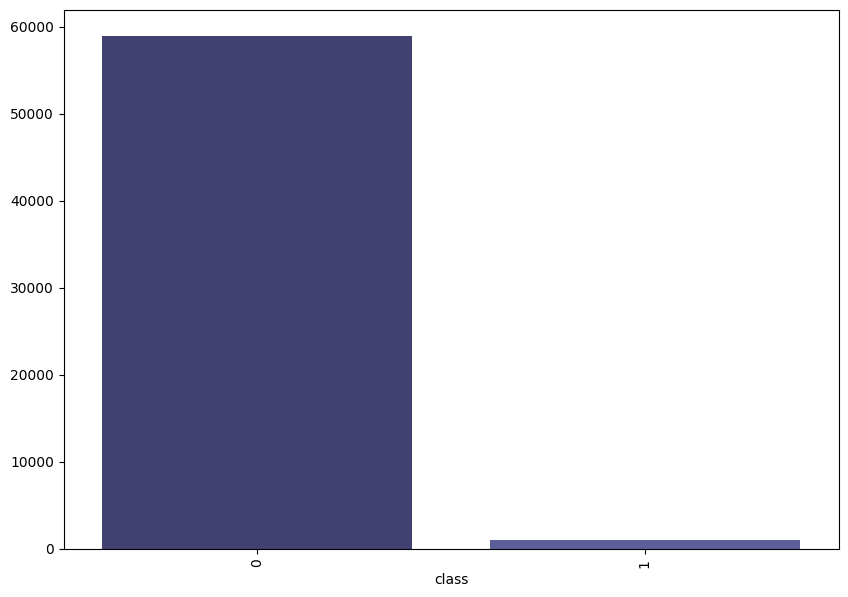

In [10]:
bar(train_labels.value_counts())
plt.show()

In [11]:
if enable_correlation and enable_dendrogram:
    corr_matrix = train_features.corr()
    dendrogram(corr_matrix)
    plt.tight_layout()

In [12]:
if enable_correlation and enable_heatmap:
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(corr_matrix, square=True, cmap='Purples', ax=ax)
    plt.tight_layout()
    plt.show()

In [13]:
# to enable run correlation selection without univariate selection.
best_train_features = train_features 
new_corr_matrix = best_train_features.corr()

In [14]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        selectKBest = SelectKBest(score_func=chi2, k=k_best)
        selectKBest.fit(train_features, train_labels)
        best_train_features = selectKBest.transform(train_features)

        idxs_selected = selectKBest.get_support(indices=True)
        best_train_features = train_features.iloc[:,idxs_selected]


In [15]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        print(best_train_features.columns) # selected columns

Index(['aa_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ah_000',
       'ai_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000',
       'ar_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_007', 'ay_008',
       'ay_009', 'az_000', 'az_001', 'az_002', 'az_005', 'ba_000', 'ba_001',
       'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_008', 'ba_009',
       'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000',
       'bi_000', 'bj_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000',
       'cc_000', 'ci_000', 'cj_000', 'ck_000', 'cl_000', 'cm_000', 'cn_000',
       'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_007', 'cn_008', 'cn_009',
       'cq_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cx_000',
       'dd_000', 'df_000', 'dn_000', 'dq_000', 'eb_000', 'ec_00', 'ee_000',
       'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007'],
      dtype='object')


In [16]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        best_train_features.describe()

In [ ]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        new_corr_matrix = best_train_features.corr()
        dendrogram(new_corr_matrix)
        plt.tight_layout()

In [18]:
if enable_correlation_selec:
    new_new_corr_matrix = corr_drop(new_corr_matrix, factor)
    print(f'Number of features selected is {len(new_new_corr_matrix.columns)}.')

In [19]:
if enable_correlation_selec:
    dendrogram(new_new_corr_matrix)
    plt.tight_layout()

In [20]:
if enable_correlation_selec:
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(new_new_corr_matrix, square=True, cmap='Purples', ax=ax)
    plt.tight_layout()
    plt.show()

In [21]:
if enable_correlation_selec:
    best_train_features = best_train_features.loc[:,new_new_corr_matrix.columns]

In [22]:
if method_selec=='pca':
    pca = PCA(pca_variance)
    pca.fit(train_features)
    best_train_features = pca.transform(train_features)
    best_train_features = pd.DataFrame(best_train_features)

In [23]:
if method_selec=='pca':
    print('Number of components {pca.n_components_}')

In [24]:
# to enable run without balancing
best_train_features_balanced = best_train_features
train_labels_balanced = train_labels

In [25]:
if enable_balancing:
    idxs_pos = train_labels[train_labels==1].index
    idxs_neg = train_labels[train_labels==0].sample(n=number_samples, replace=False, random_state=0).index
    idxs_balanced = np.concatenate((idxs_pos,idxs_neg))
    best_train_features_balanced = best_train_features.loc[idxs_balanced]
    train_labels_balanced = train_labels.loc[idxs_balanced]
    print(f'Proportion balanced: {int(number_samples/1000)}/1')

best_test_features = test_features  
if enable_normalization:
    scaler.transform(best_test_features)
    best_test_features = pd.DataFrame(scaler.transform(best_test_features), columns=best_test_features.columns)
    
if enable_univariate_selec:
    if method_selec=='selectkbest':        
        X = selectKBest.transform(best_test_features)
        idxs_selected = selectKBest.get_support(indices=True)
        best_test_features = best_test_features.iloc[:,idxs_selected]
    if method_selec=='pca':        
        best_test_features = pca.transform(best_test_features)
if enable_correlation_selec:
    best_test_features = best_test_features.loc[:,new_new_corr_matrix.columns]

test_labels = test_labels.apply(round)
test_labels = test_labels.replace({-1:0})

Proportion balanced: 2/1


                                                    Model Training

In [32]:

best_train_features_balanced, train_labels_balanced = pd.read_csv('data/x_train_cleaned.csv'),pd.read_csv('data/y_train_labels_cleaned.csv')
best_test_features, test_labels = pd.read_csv('data/x_test_cleaned.csv'), pd.read_csv('data/y_test_labels_cleaned.csv')


                                                     Best So Far!!!!

In [26]:


rfc = RandomForestRegressor(n_estimators=122, max_depth=55, oob_score = True, random_state=0, n_jobs=-1)
rfc.fit(best_train_features_balanced, train_labels_balanced)
print(rfc)


y_pred = rfc.predict(best_test_features)
y_pred = np.round(y_pred)
report = classification_report(test_labels, y_pred)
print(report)


cm = confusion_matrix(test_labels, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
display(cm)

total_cost = 10*cm.fp + 500*cm.fn
print(total_cost)


RandomForestRegressor(max_depth=55, n_estimators=122, n_jobs=-1, oob_score=True,
                      random_state=0)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.40      0.98      0.57       375

    accuracy                           0.97     16000
   macro avg       0.70      0.97      0.78     16000
weighted avg       0.99      0.97      0.97     16000



,tn,fp,fn,tp
0,15079,546,7,368


0    8960
dtype: int64


In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score


hgbc = HistGradientBoostingClassifier(learning_rate=0.4,max_depth=20,min_samples_leaf=20,max_bins=30, random_state=42)
rbc = RandomForestClassifier(n_jobs=-1)
# rfc = RandomForestRegressor(n_estimators=122, max_depth=55, oob_score = True, random_state=0, n_jobs=-1)

voting_regressor = VotingClassifier(estimators=[
     ('rbc', rbc), ('hbc', hgbc)], voting='soft')

# Fit the VotingRegressor
voting_regressor.fit(best_train_features_balanced, train_labels_balanced)


y_pred = voting_regressor.predict(best_test_features)
y_pred = np.round(y_pred)
report = classification_report(test_labels, y_pred)


cm = confusion_matrix(test_labels, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
print(cm)

total_cost = 10*cm.fp + 500*cm.fn
print(total_cost)


      tn   fp  fn   tp
0  15159  466  10  365
0    9660
dtype: int64


In [28]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import GridSearchCV, cross_val_score


# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create the RandomForestClassifier
# rf_clf = RandomForestClassifier(random_state=42)

# # Perform the grid search with cross-validation
# grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(best_train_features_balanced, train_labels_balanced)

In [29]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Training classifiers
clf1 = AdaBoostClassifier(random_state=0)
clf2 = BaggingClassifier(random_state=0, n_jobs=-1)
clf4 = ExtraTreesClassifier(random_state=0, n_jobs=-1)
clf5 = GradientBoostingClassifier()
clf6 = LogisticRegression(n_jobs=-1)
clf7 = HistGradientBoostingClassifier()
clf8 = RandomForestClassifier(n_jobs=-1)

for clf in [clf1, clf2,clf4, clf5, clf6, clf7,clf8]:
   
    clf.fit(best_train_features_balanced, train_labels_balanced)

    y_pred = clf.predict(best_test_features)
    y_pred = np.round(y_pred)
    report = classification_report(test_labels, y_pred)
    
    
    cm = confusion_matrix(test_labels, y_pred).ravel()
    cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
    # print(cm)
    
    total_cost = 10*cm.fp + 500*cm.fn
    print(total_cost)
    


0    13820
dtype: int64
0    15290
dtype: int64
0    10930
dtype: int64


KeyboardInterrupt: 

NN

In [ ]:

x_train, x_label = best_train_features_balanced.values, train_labels_balanced.values
x_test, y_test = best_test_features.values, test_labels.values



In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ipdb 

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        x = torch.tensor(self.data[index])
        y = torch.tensor(self.labels[index])
        return x, y


train_dataset = CustomDataset(x_train, x_label)
test_dataset = CustomDataset(x_test, y_test)

dataset =[train_dataset, test_dataset]

dataloader = {}
for idx,split in enumerate(['train', 'test']):
  dataloader[split] = DataLoader(
    dataset[idx],
    batch_size=64,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
      
  )

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict, OrderedDict
from sconce import sconce

from sconce import sconce
import copy
import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
import torch.optim as optim

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(84, 32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x.float()))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x
        
model = BinaryClassifier().to('cuda')


In [ ]:
import torch.nn.functional as F

def focal_loss(input, target, gamma=2.0, alpha=0.25, reduction='mean'):
  
    bcs = nn.BCELoss()
    bce_loss = bcs(input, target)
    
    # Compute the modulating factor
    pt = torch.exp(-bce_loss)
    modulating_factor = (1 - pt) ** gamma
    
    # Compute the final loss
    focal_loss = alpha * modulating_factor * bce_loss
    
    if reduction == 'mean':
        return focal_loss.mean()
    elif reduction == 'sum':
        return focal_loss.sum()
    else:
        return focal_loss

In [ ]:
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-7)

from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = focal_loss(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(dataloader['train']):.4f}")

    # Testing loop
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader['test']:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
        print(f"Test Accuracy: {100 * correct / total:.2f}%")
    scheduler.step()

In [ ]:
y_pred = model(torch.tensor(x_test).to('cuda'))



In [ ]:
y_pred

In [ ]:
y_pred = torch.argmax(y_pred,dim=1).cpu().numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)

cm = confusion_matrix(test_labels, y_pred)#.ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
print(cm)

total_cost = 10*cm.fp + 500*cm.fn
print(total_cost)